In [1]:
# The goal of this notebook will be to quantify the beta distribution for every trial, and then look only at bout switches, and see where he visits 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import statistics
from scipy.optimize import curve_fit
import math 
from scipy.stats import binom
import seaborn as sns
from scipy import stats
import matplotlib.patches as mpatches
from scipy.stats import beta
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats



In [3]:
df = pd.read_csv (r'/home/emonroe/Downloads/20210531_toEM/behavior_csv/senor_clean_contingencies_only_parsed_data.csv')

In [4]:
df['day']= df['date'].ne(df['date'].shift()).cumsum()
#df['diff_cont'] = df.groupby(['day','session'],group_keys=True)['contingency']
df['diff_cont'] = df['contingency'].ne(df['contingency'].shift())


df['cont_num'] = df.groupby(['day','session'])['diff_cont'].cumsum()
del df['diff_cont']
df['new_cont'] = df['cont_num'].ne(df['cont_num'].shift()).cumsum() #count from 1:222 for senor, eevry contingency numbered incremet

df['day_chng'] = df['day'].ne(df['day'].shift()) #T/F , first trial of new day T
df['stem_switch'] = df['stem'].ne(df['stem'].shift()) #T/F when he switches stems 
for ix in range(len(df)):
    if df.loc[ix,'trial']==0:
        df.loc[ix,'stem_switch']= True
df['bout_num'] = df['stem'].ne(df['stem'].shift()).cumsum() #incremnts each bout 



# df["stemChange"] = (df["stem"].shift(1, fill_value=df["stem"].head(1)) != df["stem"]).astype(int) #better way to calc?
for ix in range(len(df)): #find the global nominal average 
    cont= str(df.loc[ix, 'contingency'])
    cont = [cont[i:i+2] for i in range(0, len(cont), 2)]
    cont = [int(i) for i in cont]
    df.loc[ix, 'glob_nom_avg'] = statistics.mean(cont)
#     for counter in range(6):
#         df.loc[ix,f'leaf{counter+1}'] = cont[counter]
df['sess_chng'] = df['session'].ne(df['session'].shift()).cumsum()
obj = ['day', 'session', 'stem']

df['rew_count_session'] = df.groupby(obj)[['reward']].cumsum()
# obj1 = ['day', 'session', 'stem','cont_num']
# df[]
df[0:5]

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,new_cont,day_chng,stem_switch,bout_num,glob_nom_avg,sess_chng,rew_count_session
0,0,4,B,1,805020202050,20201028,1,0,1,1,1,True,True,1,40.0,1,1
1,1,1,A,0,805020202050,20201028,1,1,1,1,1,False,True,2,40.0,1,0
2,2,2,A,0,805020202050,20201028,1,2,1,1,1,False,False,2,40.0,1,0
3,3,3,B,1,805020202050,20201028,1,3,1,1,1,False,True,3,40.0,1,2
4,4,4,B,0,805020202050,20201028,1,4,1,1,1,False,False,3,40.0,1,2


In [5]:
df.loc[df.stem == "A", "ChooseA"] = 1
df.loc[df.stem == "B", "ChooseB"] = 1
df.loc[df.stem == "C", "ChooseC"] = 1
df['ChooseA'] = df['ChooseA'].fillna(0)
df['ChooseB'] = df['ChooseB'].fillna(0)
df['ChooseC'] = df['ChooseC'].fillna(0)

In [6]:
df[0:5]

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,new_cont,day_chng,stem_switch,bout_num,glob_nom_avg,sess_chng,rew_count_session,ChooseA,ChooseB,ChooseC
0,0,4,B,1,805020202050,20201028,1,0,1,1,1,True,True,1,40.0,1,1,0.0,1.0,0.0
1,1,1,A,0,805020202050,20201028,1,1,1,1,1,False,True,2,40.0,1,0,1.0,0.0,0.0
2,2,2,A,0,805020202050,20201028,1,2,1,1,1,False,False,2,40.0,1,0,1.0,0.0,0.0
3,3,3,B,1,805020202050,20201028,1,3,1,1,1,False,True,3,40.0,1,2,0.0,1.0,0.0
4,4,4,B,0,805020202050,20201028,1,4,1,1,1,False,False,3,40.0,1,2,0.0,1.0,0.0


In [7]:
df['visitsA_sesh'] = df.groupby(['day','session'])[['ChooseA']].cumsum()
df['visitsB_sesh'] = df.groupby(['day','session'])[['ChooseB']].cumsum()
df['visitsC_sesh'] = df.groupby(['day','session'])[['ChooseC']].cumsum()
df[0:5]

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,...,bout_num,glob_nom_avg,sess_chng,rew_count_session,ChooseA,ChooseB,ChooseC,visitsA_sesh,visitsB_sesh,visitsC_sesh
0,0,4,B,1,805020202050,20201028,1,0,1,1,...,1,40.0,1,1,0.0,1.0,0.0,0.0,1.0,0.0
1,1,1,A,0,805020202050,20201028,1,1,1,1,...,2,40.0,1,0,1.0,0.0,0.0,1.0,1.0,0.0
2,2,2,A,0,805020202050,20201028,1,2,1,1,...,2,40.0,1,0,1.0,0.0,0.0,2.0,1.0,0.0
3,3,3,B,1,805020202050,20201028,1,3,1,1,...,3,40.0,1,2,0.0,1.0,0.0,2.0,2.0,0.0
4,4,4,B,0,805020202050,20201028,1,4,1,1,...,3,40.0,1,2,0.0,1.0,0.0,2.0,3.0,0.0


In [8]:
df['rew_a']= df[df['ChooseA']==1]['rew_count_session']
df['rew_b']= df[df['ChooseB']==1]['rew_count_session']
df['rew_c']= df[df['ChooseC']==1]['rew_count_session']
df

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,...,rew_count_session,ChooseA,ChooseB,ChooseC,visitsA_sesh,visitsB_sesh,visitsC_sesh,rew_a,rew_b,rew_c
0,0,4,B,1,805020202050,20201028,1,0,1,1,...,1,0.0,1.0,0.0,0.0,1.0,0.0,NaN,1.0,NaN
1,1,1,A,0,805020202050,20201028,1,1,1,1,...,0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN
2,2,2,A,0,805020202050,20201028,1,2,1,1,...,0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,NaN,NaN
3,3,3,B,1,805020202050,20201028,1,3,1,1,...,2,0.0,1.0,0.0,2.0,2.0,0.0,NaN,2.0,NaN
4,4,4,B,0,805020202050,20201028,1,4,1,1,...,2,0.0,1.0,0.0,2.0,3.0,0.0,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13288,13288,2,A,1,508020208020,20201107,6,175,11,3,...,28,1.0,0.0,0.0,46.0,71.0,59.0,28.0,NaN,NaN
13289,13289,1,A,0,508020208020,20201107,6,176,11,3,...,28,1.0,0.0,0.0,47.0,71.0,59.0,28.0,NaN,NaN
13290,13290,2,A,0,508020208020,20201107,6,177,11,3,...,28,1.0,0.0,0.0,48.0,71.0,59.0,28.0,NaN,NaN
13291,13291,1,A,1,508020208020,20201107,6,178,11,3,...,29,1.0,0.0,0.0,49.0,71.0,59.0,29.0,NaN,NaN


In [9]:

for ix in range(len(df)):
    if df.loc[ix,'trial']==0:
        if df.loc[ix,'ChooseA']==0:
            df.loc[ix,'rew_a'] =0
for ix in range(len(df)):
    if df.loc[ix,'trial']==0:
        if df.loc[ix,'ChooseC']==0:
            df.loc[ix,'rew_c'] =0
for ix in range(len(df)):
    if df.loc[ix,'trial']==0:
        if df.loc[ix,'ChooseB']==0:
            df.loc[ix,'rew_b'] =0     

In [10]:
df

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,...,rew_count_session,ChooseA,ChooseB,ChooseC,visitsA_sesh,visitsB_sesh,visitsC_sesh,rew_a,rew_b,rew_c
0,0,4,B,1,805020202050,20201028,1,0,1,1,...,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,1,A,0,805020202050,20201028,1,1,1,1,...,0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN
2,2,2,A,0,805020202050,20201028,1,2,1,1,...,0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,NaN,NaN
3,3,3,B,1,805020202050,20201028,1,3,1,1,...,2,0.0,1.0,0.0,2.0,2.0,0.0,NaN,2.0,NaN
4,4,4,B,0,805020202050,20201028,1,4,1,1,...,2,0.0,1.0,0.0,2.0,3.0,0.0,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13288,13288,2,A,1,508020208020,20201107,6,175,11,3,...,28,1.0,0.0,0.0,46.0,71.0,59.0,28.0,NaN,NaN
13289,13289,1,A,0,508020208020,20201107,6,176,11,3,...,28,1.0,0.0,0.0,47.0,71.0,59.0,28.0,NaN,NaN
13290,13290,2,A,0,508020208020,20201107,6,177,11,3,...,28,1.0,0.0,0.0,48.0,71.0,59.0,28.0,NaN,NaN
13291,13291,1,A,1,508020208020,20201107,6,178,11,3,...,29,1.0,0.0,0.0,49.0,71.0,59.0,29.0,NaN,NaN


In [11]:
for col in ['rew_a','rew_b','rew_c']:
    df[col] = df[col].fillna(method='ffill')

In [12]:
df[0:5]

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,...,rew_count_session,ChooseA,ChooseB,ChooseC,visitsA_sesh,visitsB_sesh,visitsC_sesh,rew_a,rew_b,rew_c
0,0,4,B,1,805020202050,20201028,1,0,1,1,...,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,1,A,0,805020202050,20201028,1,1,1,1,...,0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,2,2,A,0,805020202050,20201028,1,2,1,1,...,0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0
3,3,3,B,1,805020202050,20201028,1,3,1,1,...,2,0.0,1.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0
4,4,4,B,0,805020202050,20201028,1,4,1,1,...,2,0.0,1.0,0.0,2.0,3.0,0.0,0.0,2.0,0.0


In [22]:
# df[175*2:185*2]

In [13]:
for ix in range(len(df)):
    num_succ_a = df.loc[ix,'rew_a']
    num_fail_a = df.loc[ix,'visitsA_sesh'] - num_succ_a
    num_succ_b = df.loc[ix,'rew_b']
    num_fail_b = df.loc[ix,'visitsB_sesh'] - num_succ_b
    num_succ_c = df.loc[ix,'rew_c']
    num_fail_c = df.loc[ix,'visitsC_sesh'] - num_succ_c
    meana, vara, skewa, kurta = beta.stats(num_succ_a+1, num_fail_a+1, moments='mvsk')
    meanb, varb, skewb, kurtb = beta.stats(num_succ_b+1, num_fail_b+1, moments='mvsk')
    meanc, varc, skewc, kurtc = beta.stats(num_succ_c+1, num_fail_c+1, moments='mvsk')
    df.loc[ix,'meanA'] = meana
    df.loc[ix,'varA'] = vara
    df.loc[ix,'meanB'] = meanb
    df.loc[ix,'varB'] = varb
    df.loc[ix,'meanC'] = meanc
    df.loc[ix,'varC'] = varc

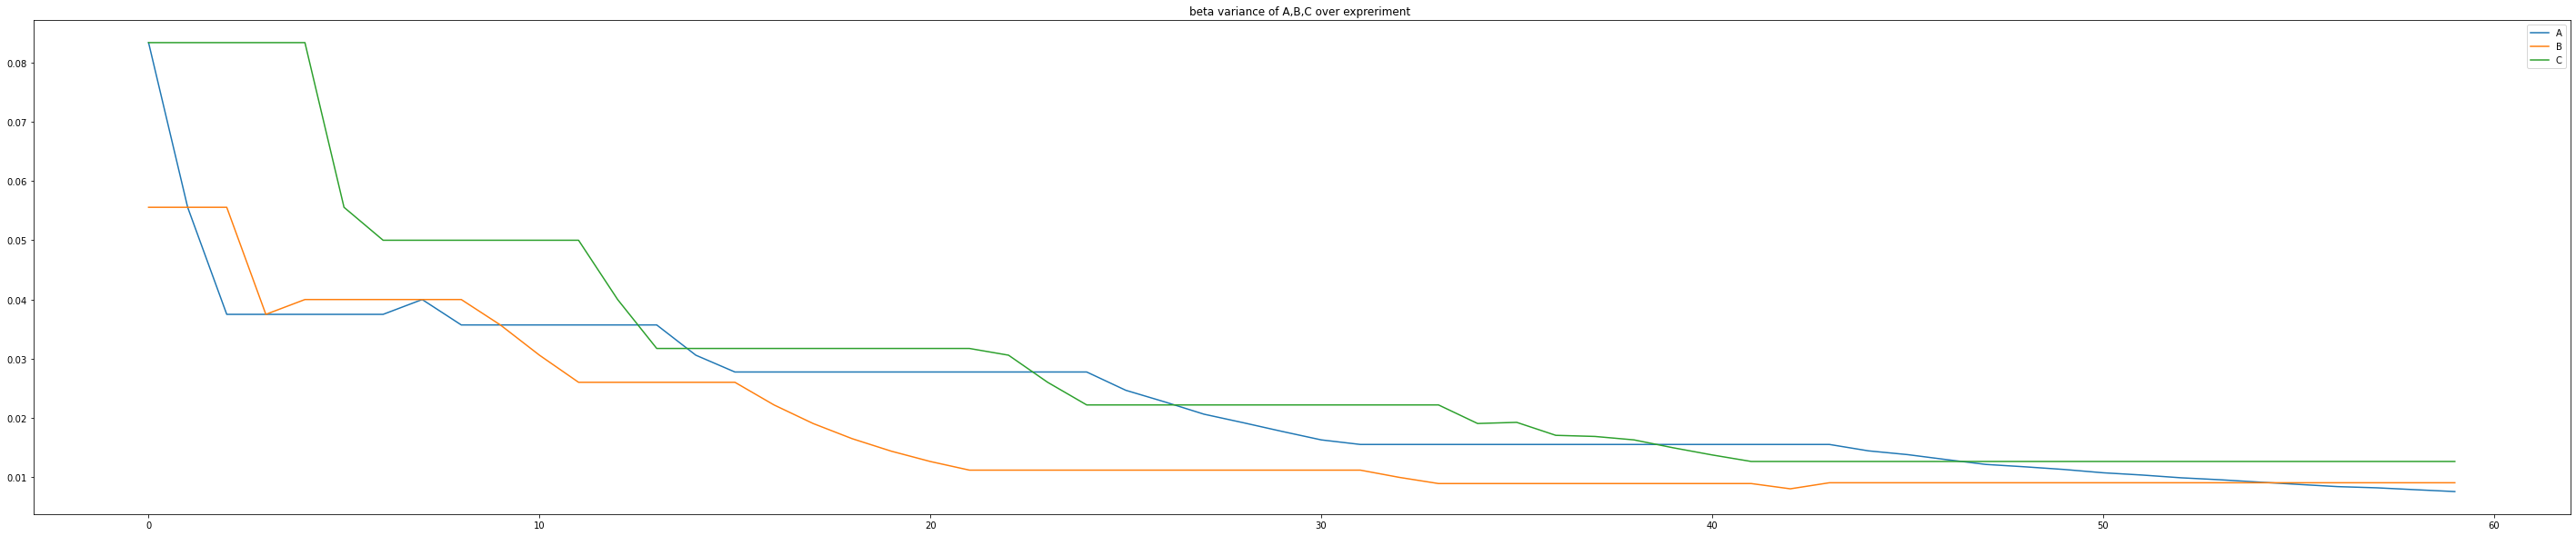

In [14]:
df1=df[0:60]
plt.figure(figsize=(50,10))
plt.plot(df1.varA)
plt.plot(df1.varB)
plt.plot(df1.varC)
plt.title('beta variance of A,B,C over expreriment ')
plt.legend(['A','B','C'])
#plt.vlines((60,120),0,1,colors='red', ls='--',alpha=0.5)



In [16]:
stemsw = df1[df1['stem_switch']]
stemsw

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,...,visitsC_sesh,rew_a,rew_b,rew_c,meanA,varA,meanB,varB,meanC,varC
0,0,4,B,1,805020202050,20201028,1,0,1,1,...,0.0,0.0,1.0,0.0,0.500000,0.083333,0.666667,0.055556,0.500000,0.083333
1,1,1,A,0,805020202050,20201028,1,1,1,1,...,0.0,0.0,1.0,0.0,0.333333,0.055556,0.666667,0.055556,0.500000,0.083333
3,3,3,B,1,805020202050,20201028,1,3,1,1,...,0.0,0.0,2.0,0.0,0.250000,0.037500,0.750000,0.037500,0.500000,0.083333
5,5,5,C,0,805020202050,20201028,1,5,1,1,...,1.0,0.0,2.0,0.0,0.250000,0.037500,0.600000,0.040000,0.333333,0.055556
7,7,1,A,1,805020202050,20201028,1,7,1,1,...,2.0,1.0,2.0,1.0,0.400000,0.040000,0.600000,0.040000,0.500000,0.050000
9,9,3,B,0,805020202050,20201028,1,9,1,1,...,2.0,2.0,2.0,1.0,0.500000,0.035714,0.500000,0.035714,0.500000,0.050000
12,12,5,C,0,805020202050,20201028,1,12,1,1,...,3.0,2.0,2.0,1.0,0.500000,0.035714,0.375000,0.026042,0.400000,0.040000
14,14,1,A,1,805020202050,20201028,1,14,1,1,...,4.0,3.0,2.0,1.0,0.571429,0.030612,0.375000,0.026042,0.333333,0.031746
16,16,3,B,0,805020202050,20201028,1,16,1,1,...,4.0,3.0,2.0,1.0,0.500000,0.027778,0.333333,0.022222,0.333333,0.031746
22,22,6,C,1,805020202050,20201028,1,22,1,1,...,5.0,3.0,2.0,2.0,0.500000,0.027778,0.214286,0.011224,0.428571,0.030612


In [17]:
index = stemsw.iloc[1][0]

var_option1= df1.iloc[index-1]['varA']
var_option1

0.08333333333333333

In [18]:
stemsw_ix = df1['stem_switch']

In [19]:
#so, starting after 0. 
#He goes from B, has go choose between A and C. CHooses to go to A, so proportion is A/C. 
#using index-1 because need the values before the choice is incorporated into the beta dist. 
var_prop_lst=[]
for ix in range(1,len(stemsw)):
    index = stemsw.iloc[ix][0]
    
    stem1=stemsw.iloc[ix-1]['stem']
    stem2=stemsw.iloc[ix]['stem']
    if stem2=='A':
        if stem1 =='B':            
            var_prop= df1.iloc[index-1]['varA']/df1.iloc[index-1]['varC']
        if stem1 =='C':
            var_prop= df1.iloc[index-1]['varA']/df1.iloc[index-1]['varB']
    if stem2=='B':
        if stem1 =='A':
            var_prop= df1.iloc[index-1]['varB']/df1.iloc[index-1]['varC']
        if stem1 =='C':
            var_prop= df1.iloc[index-1]['varB']/df1.iloc[index-1]['varA']
    if stem2=='C':
        if stem1 =='A':
            var_prop= df1.iloc[index-1]['varC']/df1.iloc[index-1]['varB']
        if stem1 =='B':
            var_prop= df1.iloc[index-1]['varC']/df1.iloc[index-1]['varA']          
    var_prop_lst.append(var_prop)

1.1409801136363638

1.1666666666666667

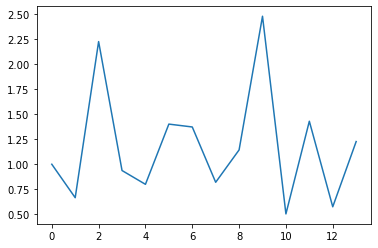

In [20]:
plt.plot(var_prop_lst)

In [56]:
df1

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,...,visitsC_sesh,rew_a,rew_c,rew_b,meanA,varA,meanB,varB,meanC,varC
0,0,4,B,1,805020202050,20201028,1,0,1,1,...,0.0,0.0,0.0,1.0,0.500000,0.083333,0.666667,0.055556,0.500000,0.083333
1,1,1,A,0,805020202050,20201028,1,1,1,1,...,0.0,0.0,0.0,1.0,0.333333,0.055556,0.666667,0.055556,0.500000,0.083333
2,2,2,A,0,805020202050,20201028,1,2,1,1,...,0.0,0.0,0.0,1.0,0.250000,0.037500,0.666667,0.055556,0.500000,0.083333
3,3,3,B,1,805020202050,20201028,1,3,1,1,...,0.0,0.0,0.0,2.0,0.250000,0.037500,0.750000,0.037500,0.500000,0.083333
4,4,4,B,0,805020202050,20201028,1,4,1,1,...,0.0,0.0,0.0,2.0,0.250000,0.037500,0.600000,0.040000,0.500000,0.083333
5,5,5,C,0,805020202050,20201028,1,5,1,1,...,1.0,0.0,0.0,2.0,0.250000,0.037500,0.600000,0.040000,0.333333,0.055556
6,6,6,C,1,805020202050,20201028,1,6,1,1,...,2.0,0.0,1.0,2.0,0.250000,0.037500,0.600000,0.040000,0.500000,0.050000
7,7,1,A,1,805020202050,20201028,1,7,1,1,...,2.0,1.0,1.0,2.0,0.400000,0.040000,0.600000,0.040000,0.500000,0.050000
8,8,2,A,1,805020202050,20201028,1,8,1,1,...,2.0,2.0,1.0,2.0,0.500000,0.035714,0.600000,0.040000,0.500000,0.050000
9,9,3,B,0,805020202050,20201028,1,9,1,1,...,2.0,2.0,1.0,2.0,0.500000,0.035714,0.500000,0.035714,0.500000,0.050000


<ipython-input-21-9be1a7a6e1e2>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


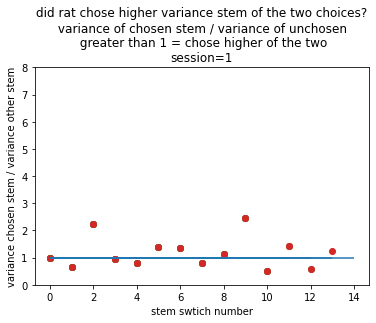

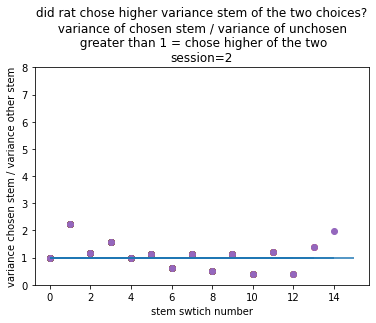

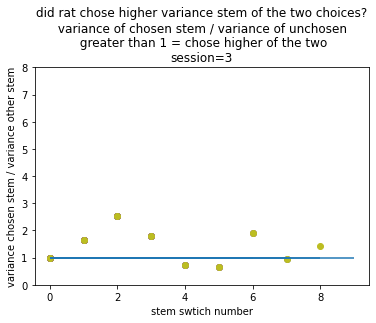

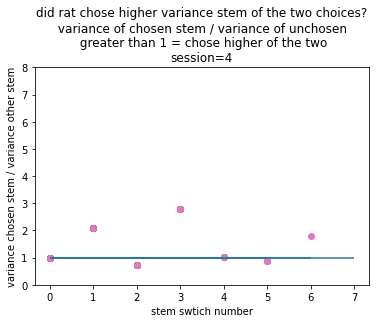

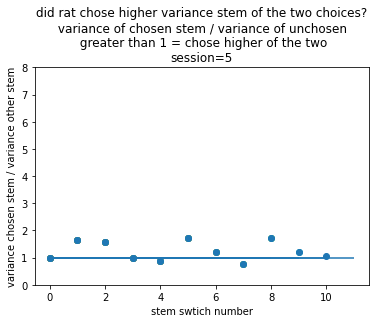

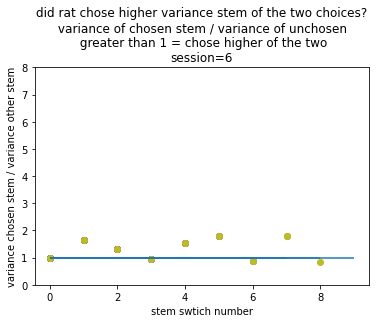

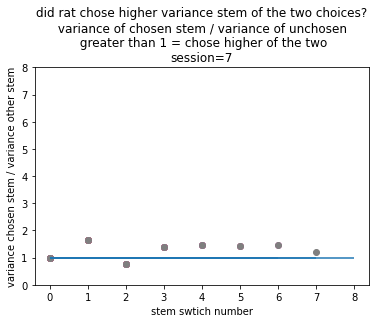

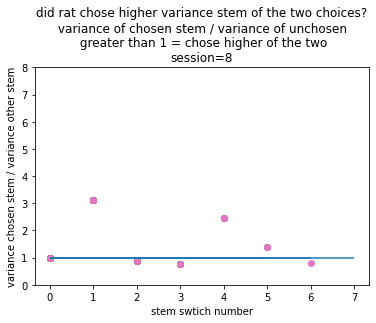

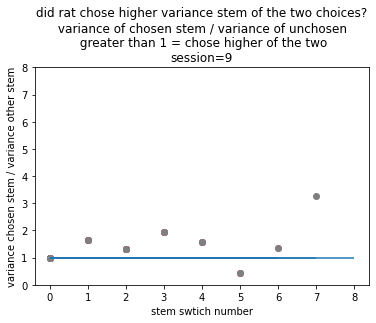

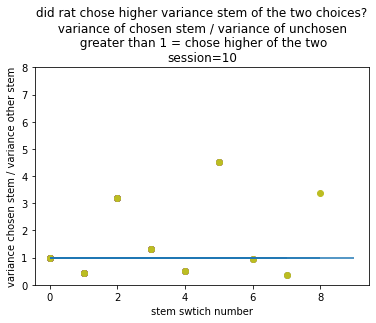

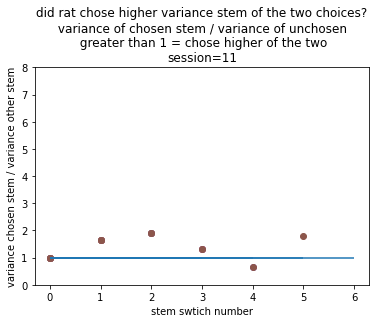

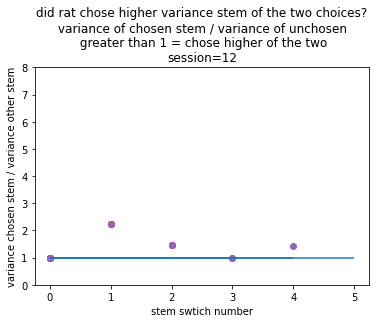

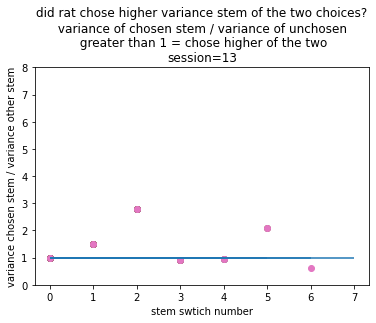

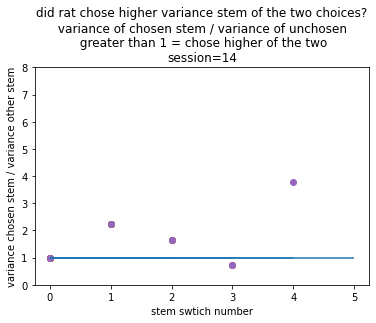

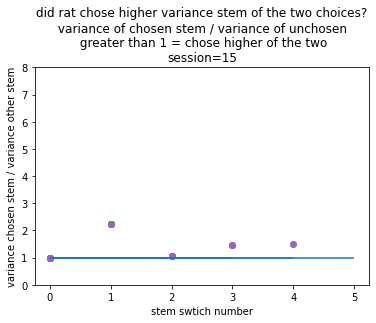

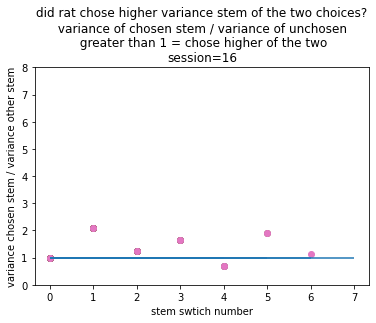

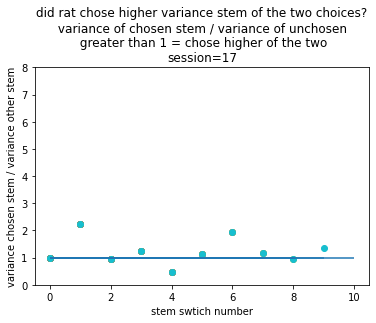

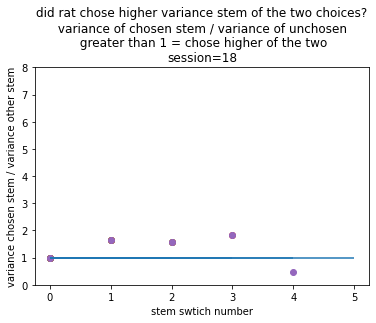

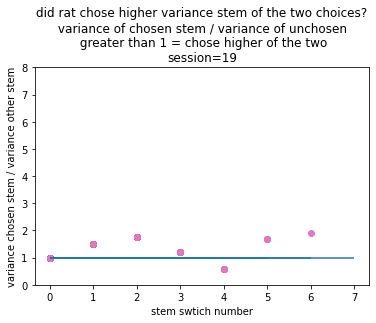

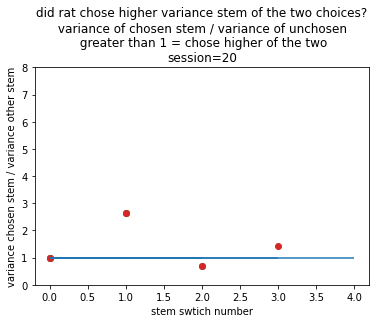

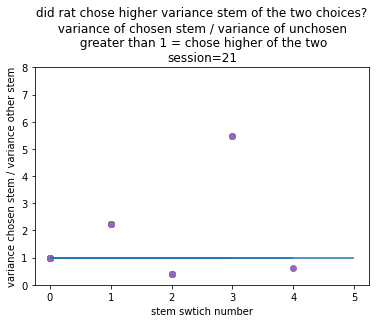

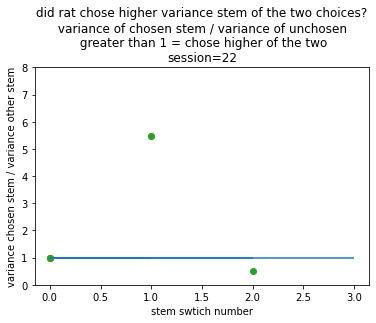

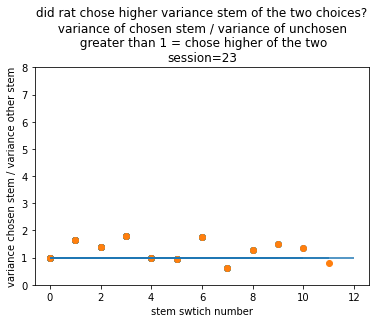

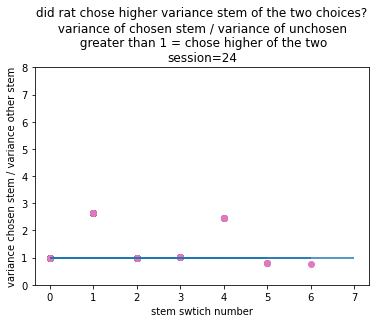

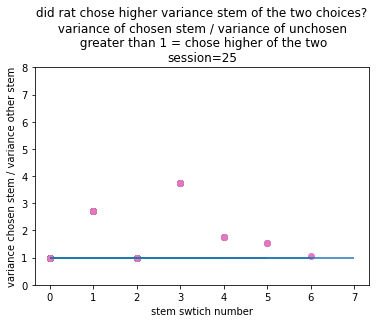

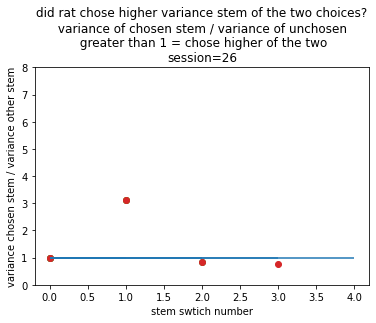

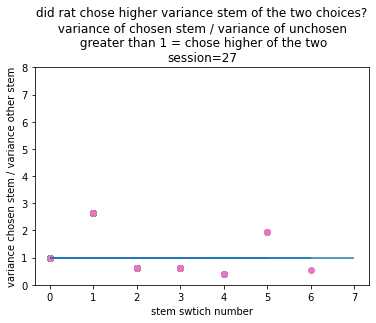

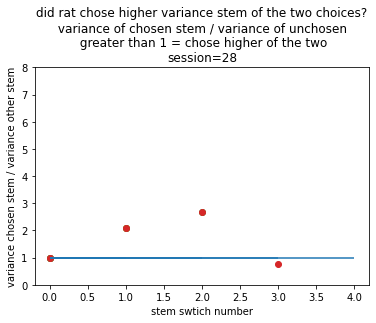

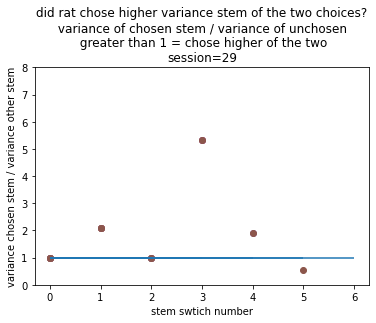

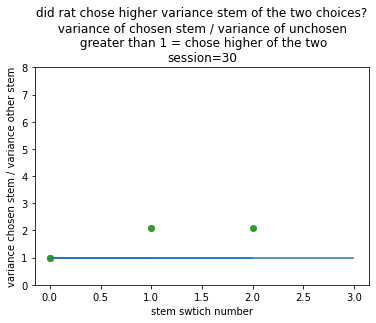

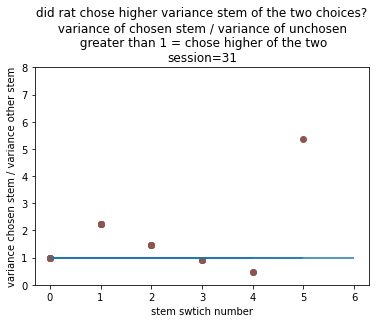

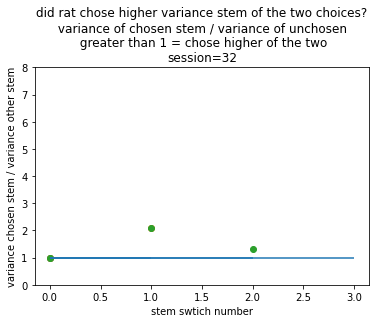

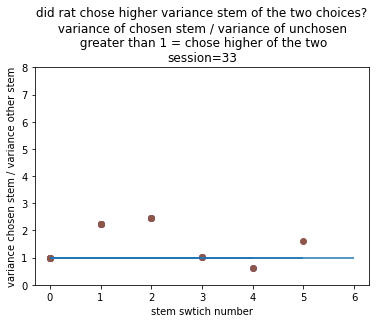

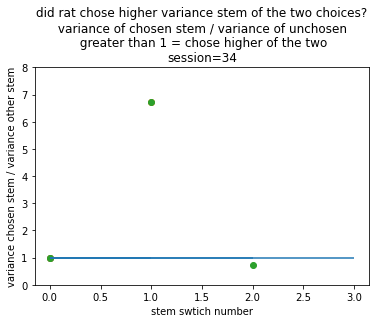

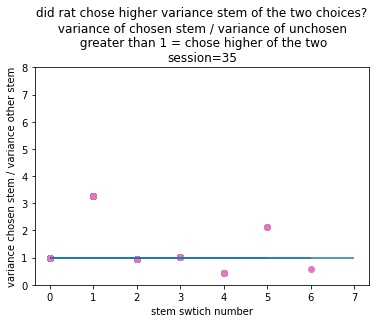

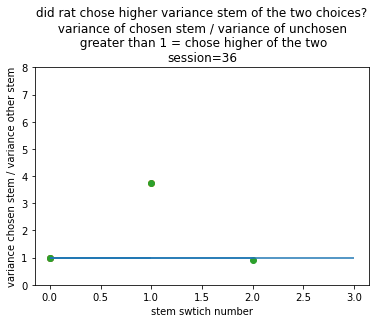

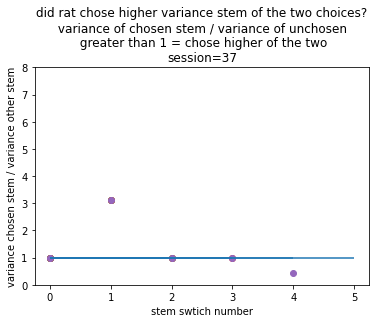

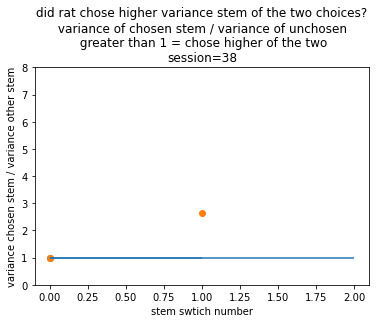

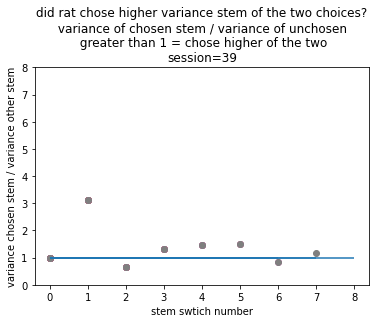

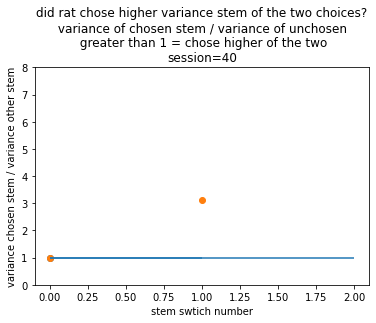

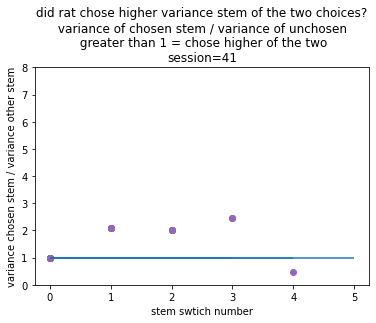

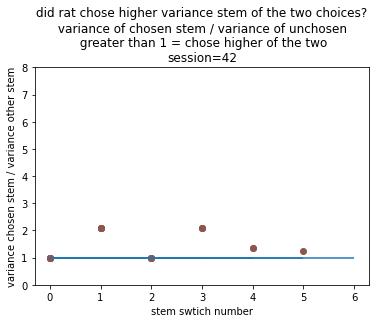

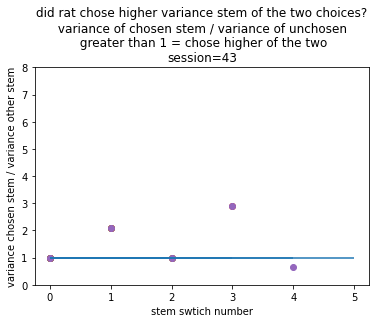

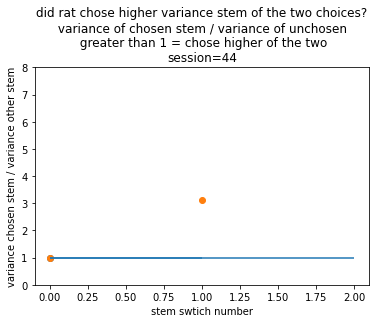

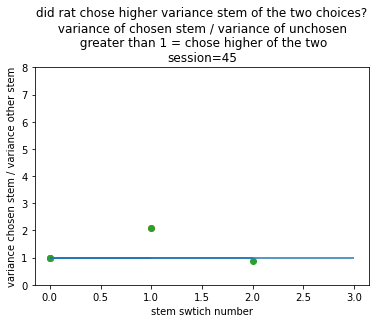

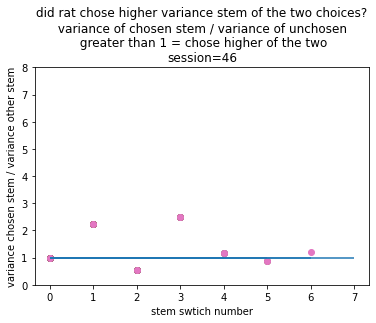

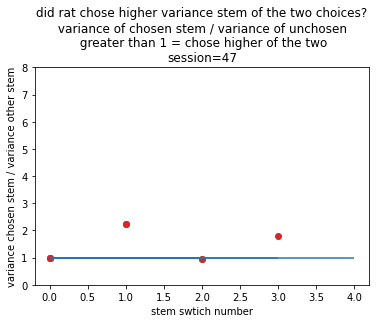

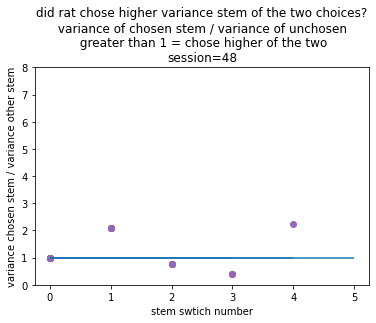

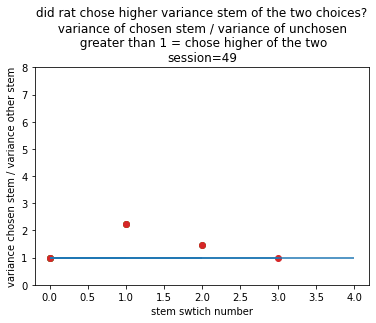

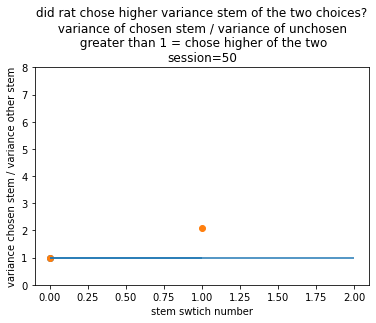

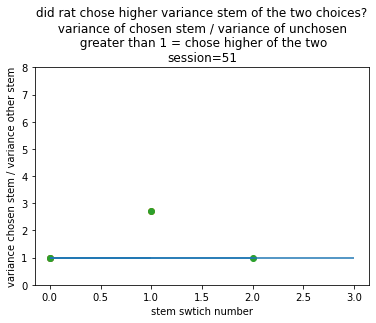

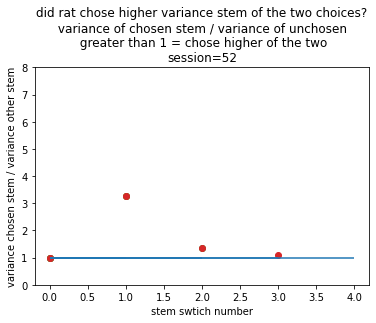

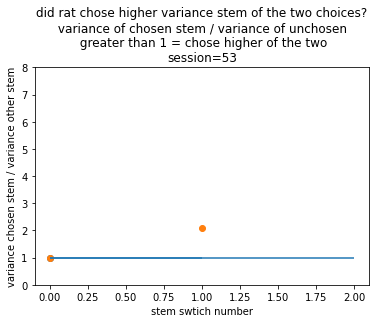

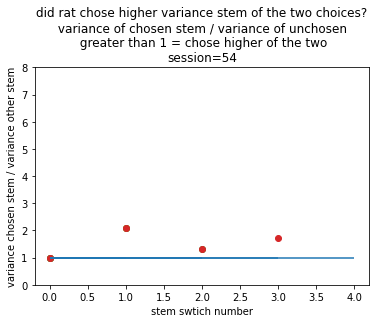

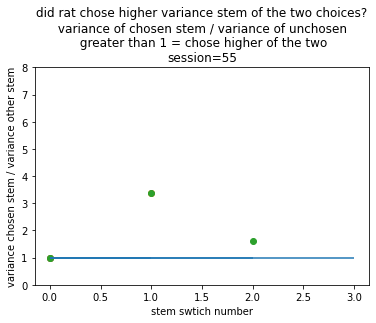

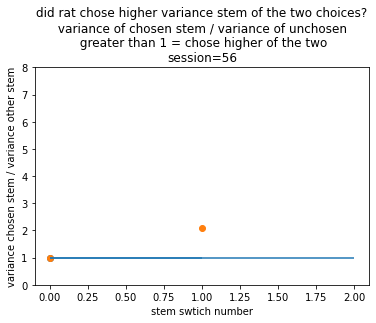

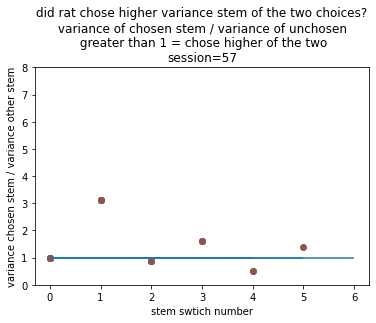

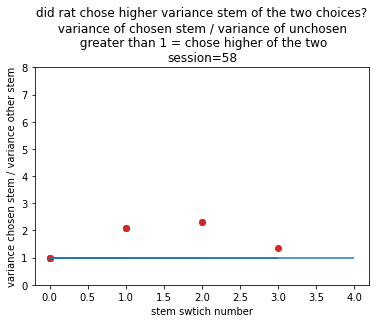

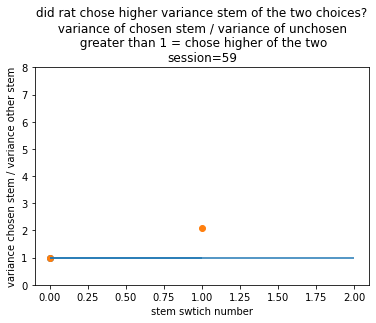

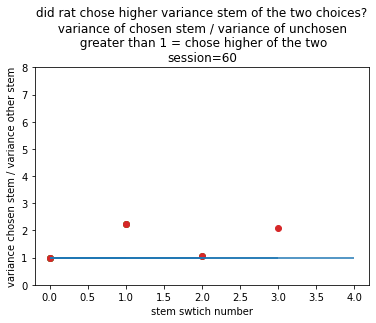

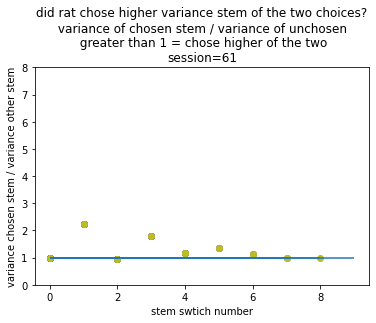

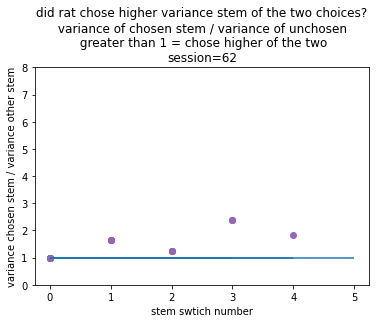

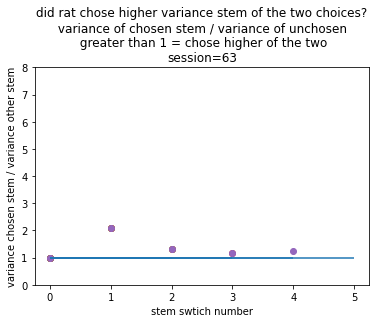

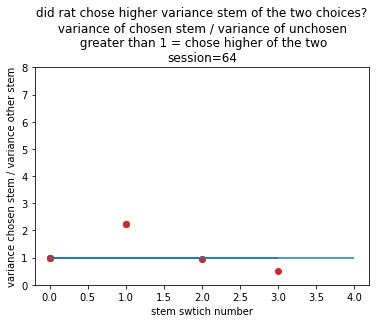

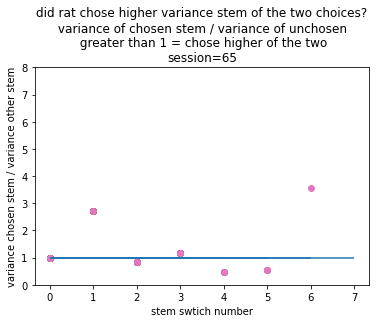

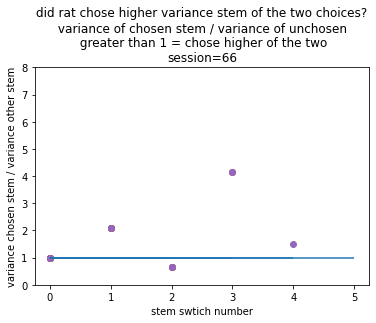

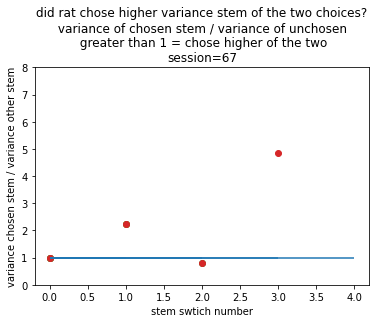

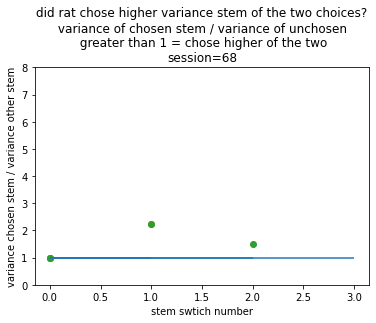

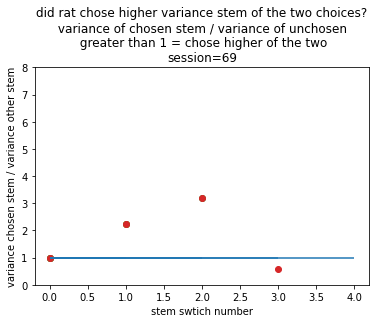

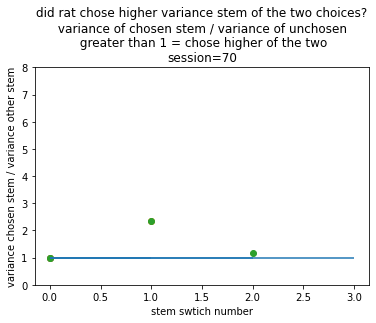

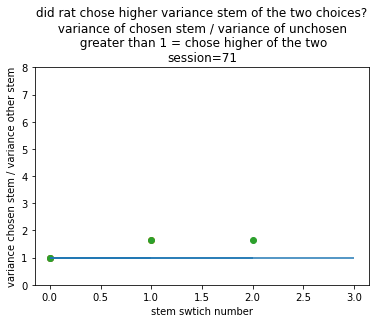

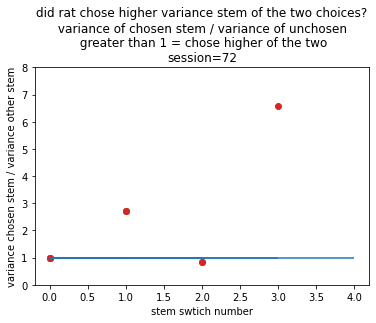

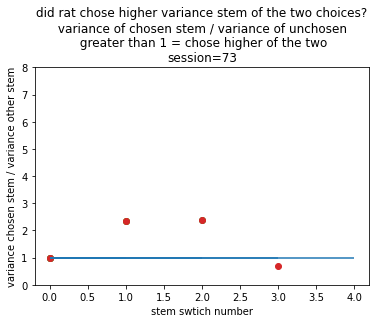

In [21]:
for sess in range(1,(df['sess_chng']).max()):
    plt.figure()
    random_session = df[df['sess_chng']==sess]
    random_session = random_session[random_session['cont_num']==1]
    stemsw = random_session[random_session['stem_switch']]
    var_prop_lst=[]
    for ix in range(1,len(stemsw)):
        index = stemsw.iloc[ix][0]

        stem1=stemsw.iloc[ix-1]['stem']
        stem2=stemsw.iloc[ix]['stem']
        if stem2=='A':
            if stem1 =='B':            
                var_prop= random_session.loc[index-1]['varA']/random_session.loc[index-1]['varC']
            if stem1 =='C':
                var_prop= random_session.loc[index-1]['varA']/random_session.loc[index-1]['varB']
        if stem2=='B':
            if stem1 =='A':
                var_prop= random_session.loc[index-1]['varB']/random_session.loc[index-1]['varC']
            if stem1 =='C':
                var_prop= random_session.loc[index-1]['varB']/random_session.loc[index-1]['varA']
        if stem2=='C':
            if stem1 =='A':
                var_prop= random_session.loc[index-1]['varC']/random_session.loc[index-1]['varB']
            if stem1 =='B':
                var_prop= random_session.loc[index-1]['varC']/random_session.loc[index-1]['varA']          
        var_prop_lst.append(var_prop)
        plt.scatter(range(len(var_prop_lst)),var_prop_lst)
        plt.ylim(0,8)
        plt.hlines(1,0,len(var_prop_lst))
        plt.xlabel('stem swtich number')
        plt.ylabel('variance chosen stem / variance other stem')
        plt.title(f'did rat chose higher variance stem of the two choices?\n variance of chosen stem / variance of unchosen \n greater than 1 = chose higher of the two\nsession={sess}')

    

In [ ]:
for sess in range(1,(df['sess_chng']).max()):
    plt.figure()
    random_session = df[df['sess_chng']==sess]
    random_session = random_session[random_session['cont_num']==1]
    stemsw = random_session[random_session['stem_switch']]
    var_prop_lst=[]
    for ix in range(1,len(stemsw)):
        index = stemsw.iloc[ix][0]

        stem1=stemsw.iloc[ix-1]['stem']
        stem2=stemsw.iloc[ix]['stem']
        if stem2=='A':
            if stem1 =='B':            
                var_prop= random_session.loc[index-1]['varA']/random_session.loc[index-1]['varC']
            if stem1 =='C':
                var_prop= random_session.loc[index-1]['varA']/random_session.loc[index-1]['varB']
        if stem2=='B':
            if stem1 =='A':
                var_prop= random_session.loc[index-1]['varB']/random_session.loc[index-1]['varC']
            if stem1 =='C':
                var_prop= random_session.loc[index-1]['varB']/random_session.loc[index-1]['varA']
        if stem2=='C':
            if stem1 =='A':
                var_prop= random_session.loc[index-1]['varC']/random_session.loc[index-1]['varB']
            if stem1 =='B':
                var_prop= random_session.loc[index-1]['varC']/random_session.loc[index-1]['varA']          
        var_prop_lst.append(var_prop)
        x=range(len(var_prop_lst))
        y= var_prop_lst
        plt.scatter(x,y)
        
        plt.ylim(0,8)
        plt.hlines(1,0,len(var_prop_lst))
        plt.xlabel('stem swtich number')
        plt.ylabel('variance chosen stem / variance other stem')
        plt.title(f'did rat chose higher variance stem of the two choices?\n variance of chosen stem / variance of unchosen \n greater than 1 = chose higher of the two\nsession={sess}')
    #     mymodel = np.poly1d(np.polyfit(x, y, 1))
    # # plt.title('for every trial, does he visit the highest mean')
    #             # plt.xlabel('session')
    #             # plt.ylabel('last significant trial at worst')
    #     # X2 = sm.add_constant(x)
    #     # est = sm.OLS(y, X2)
    #     # est2 = est.fit()
    #tries to plot line sbut did not converge 

In [76]:
index

182

In [80]:
random_session.loc[index]

Unnamed: 0                    182
leaf                            1
stem                            A
reward                          1
contingency          502020805080
date                     20201028
session                         2
trial                           2
day                             1
cont_num                        1
new_cont                        4
day_chng                    False
stem_switch                  True
bout_num                       28
glob_nom_avg                 50.0
sess_chng                       2
rew_count_session               1
ChooseA                       1.0
ChooseB                       0.0
ChooseC                       0.0
visitsA_sesh                  1.0
visitsB_sesh                  0.0
visitsC_sesh                  2.0
rew_a                         1.0
rew_c                         0.0
rew_b                         0.0
meanA                    0.666667
varA                     0.055556
meanB                         0.5
varB          

<ipython-input-23-d40de92eec10>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


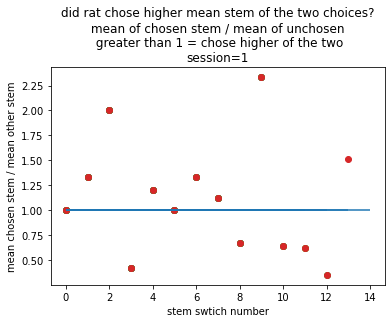

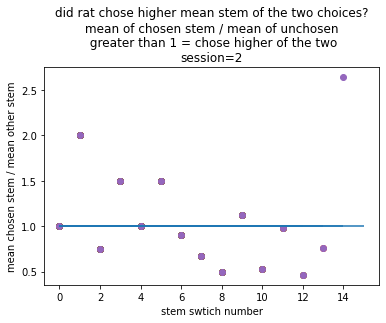

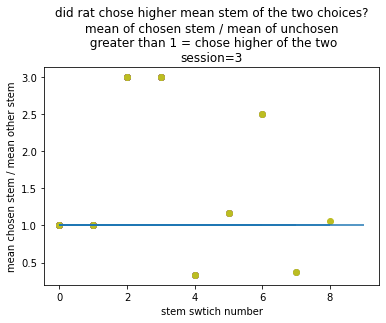

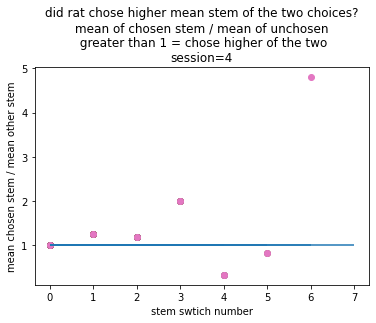

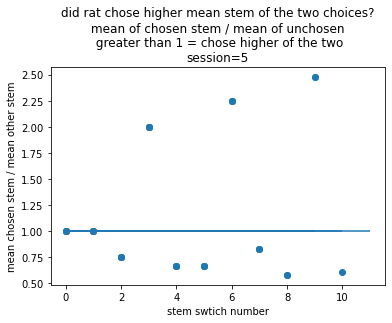

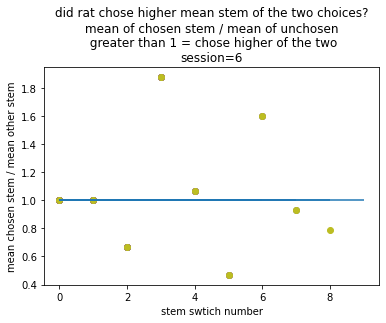

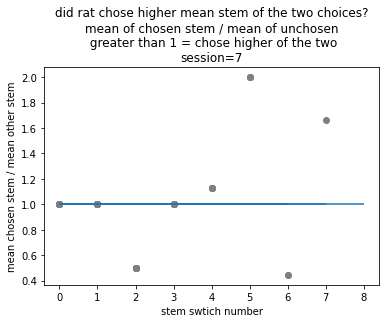

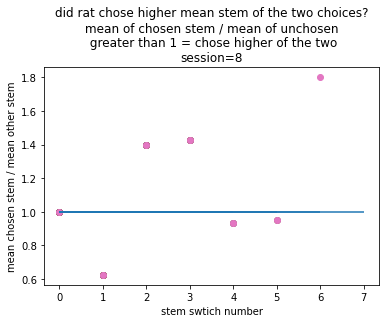

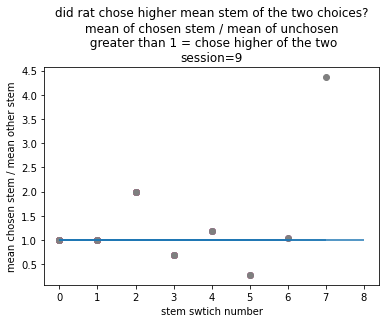

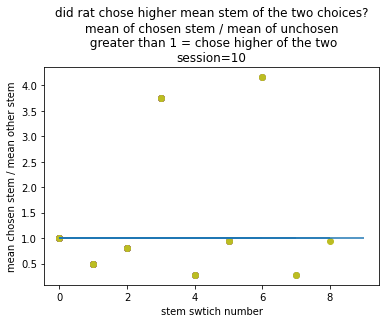

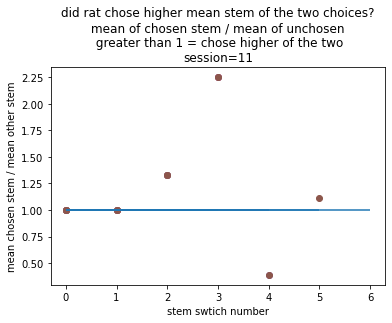

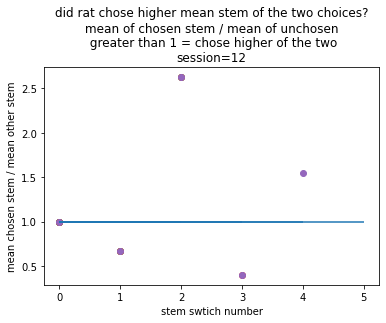

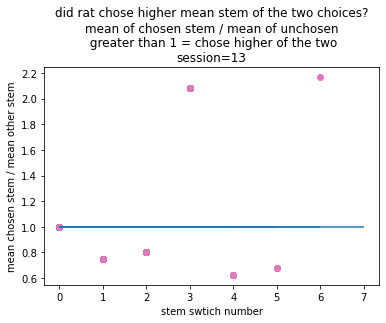

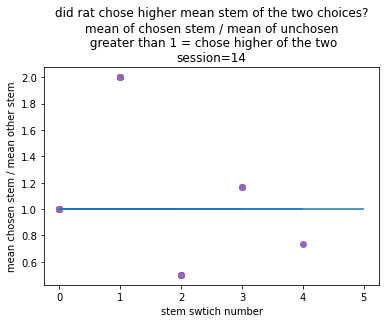

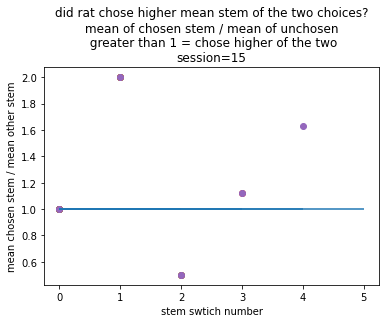

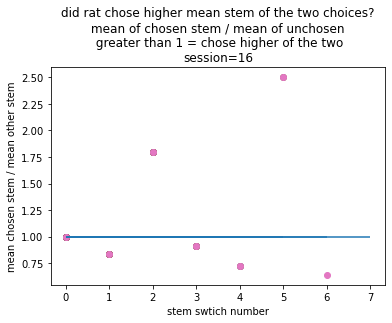

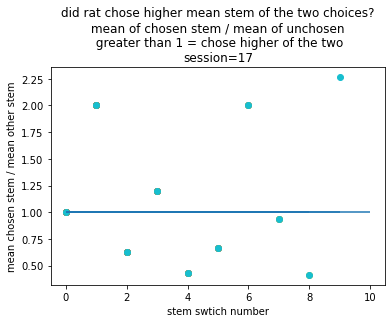

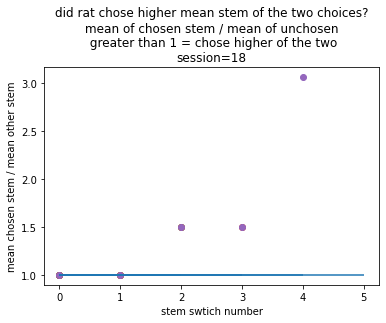

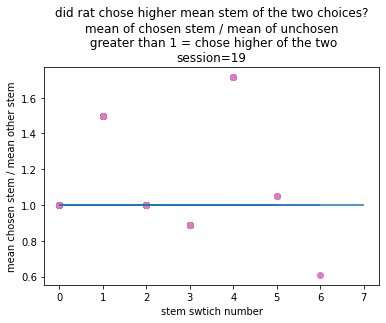

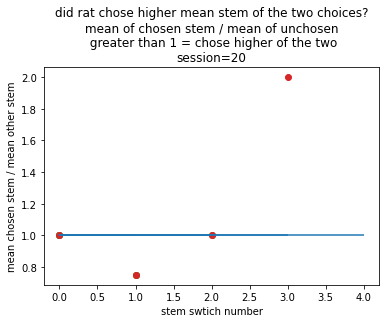

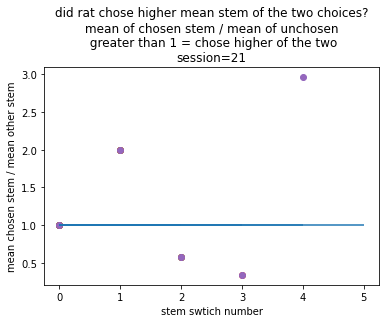

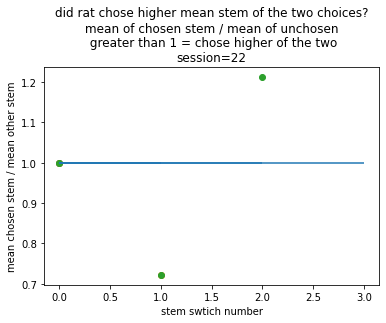

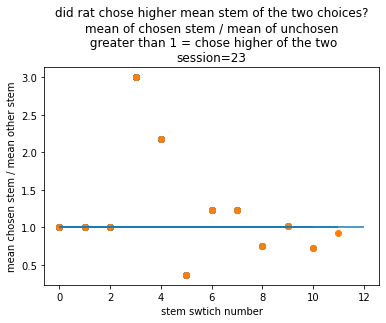

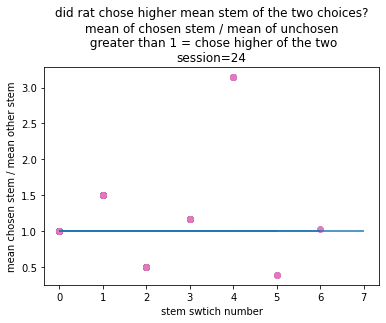

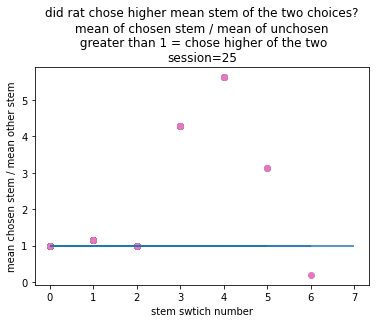

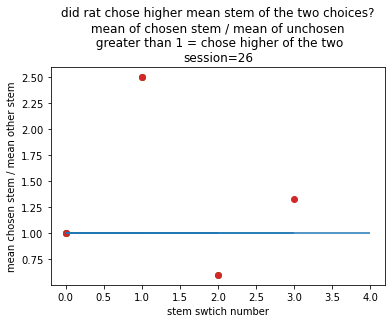

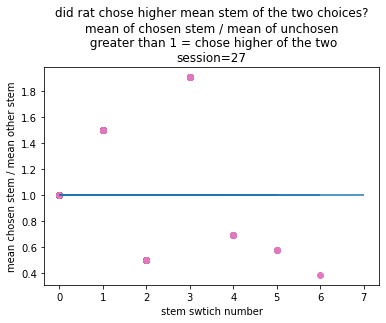

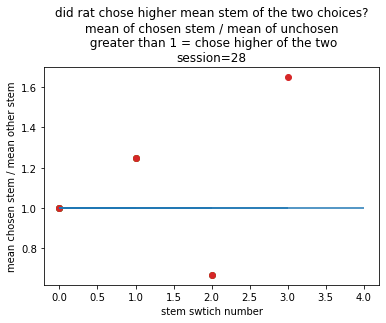

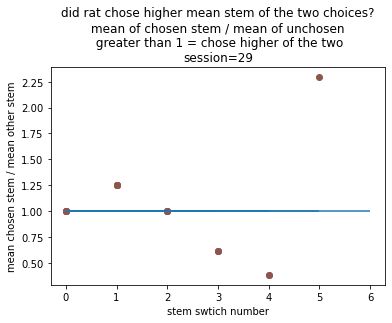

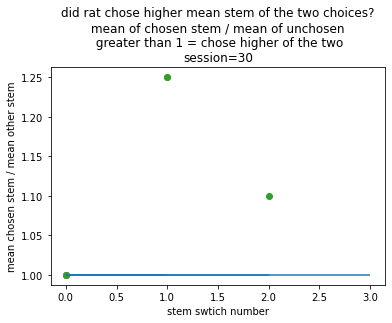

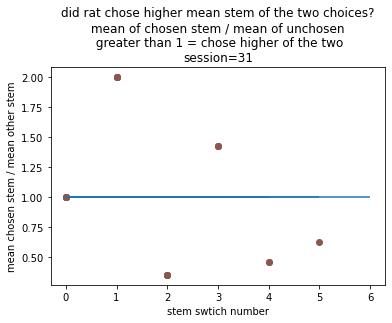

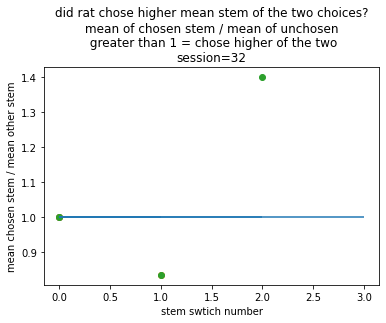

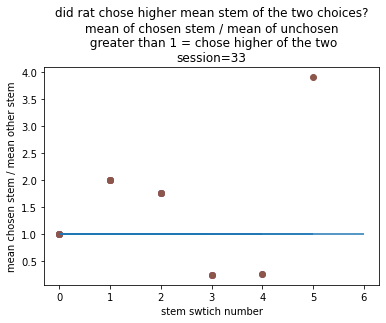

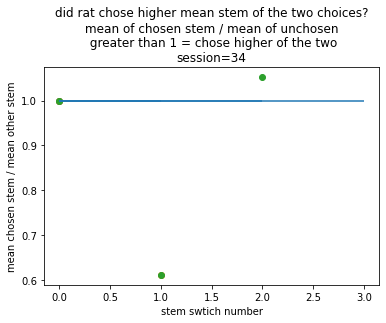

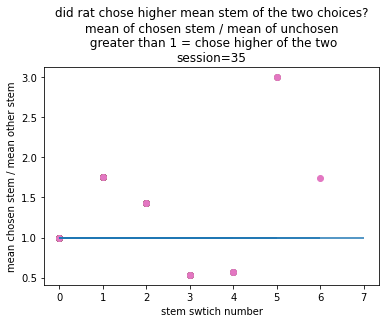

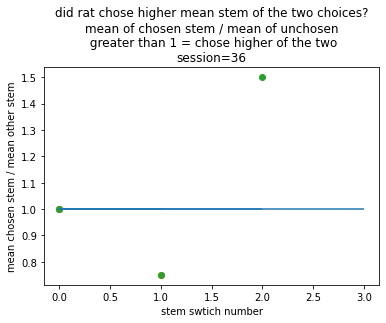

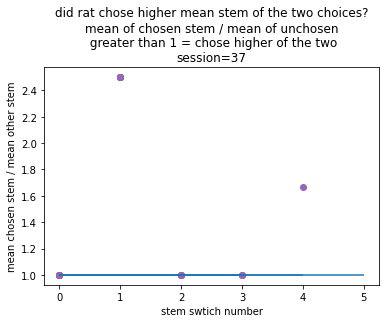

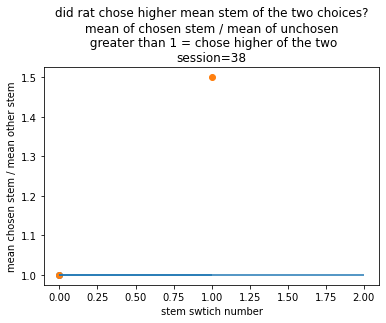

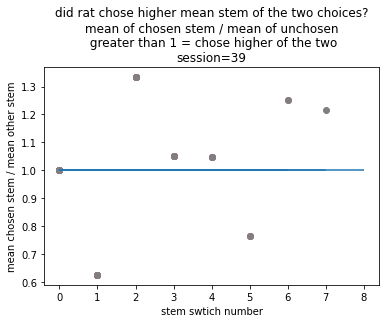

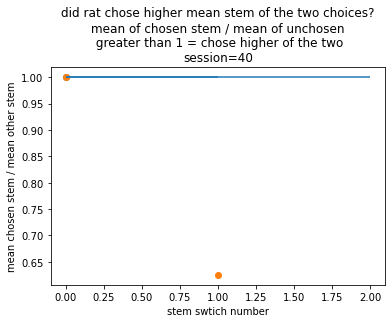

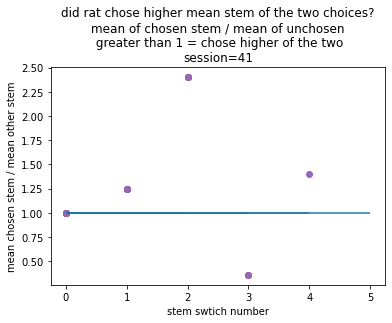

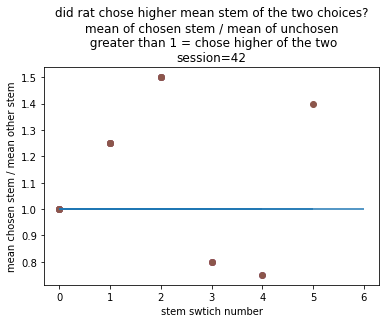

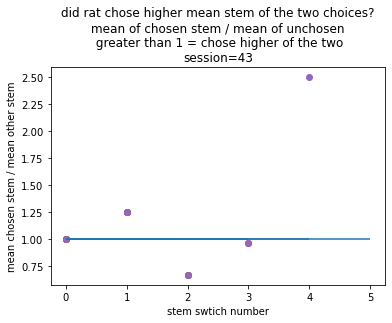

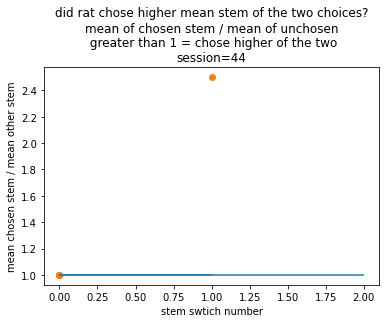

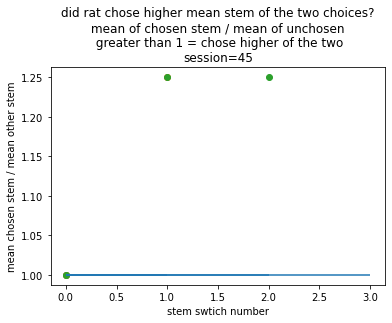

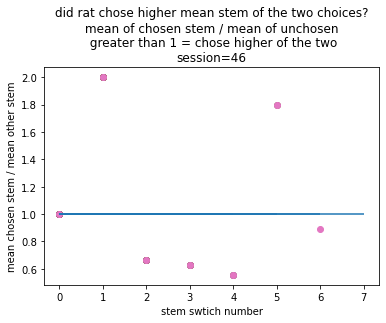

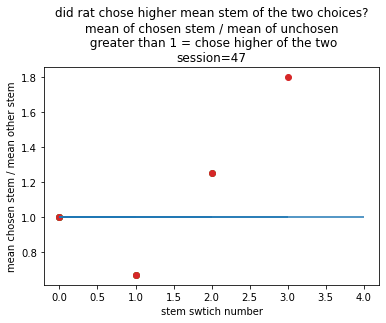

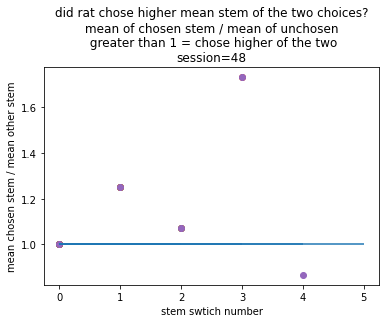

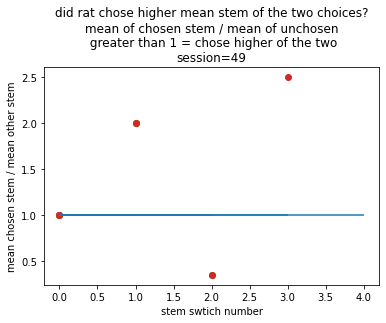

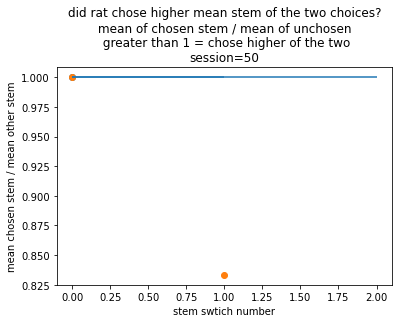

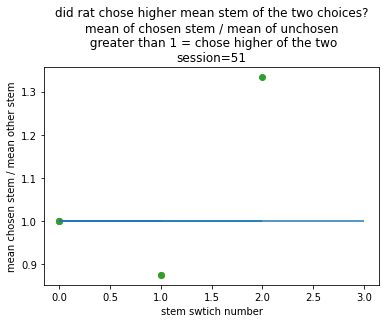

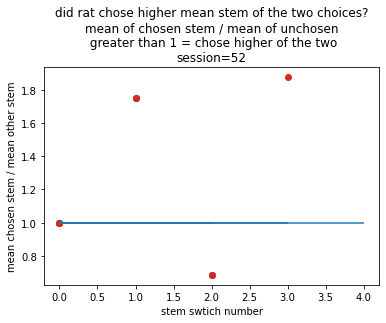

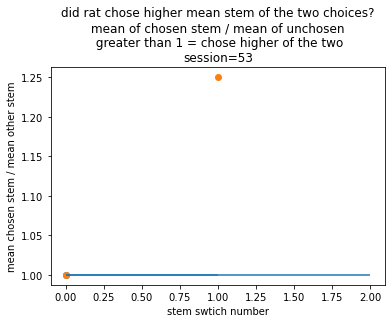

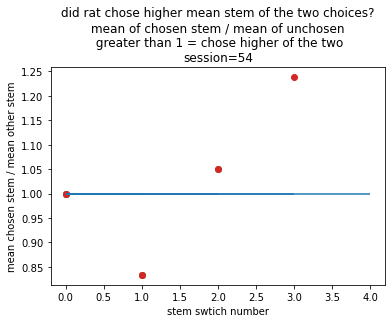

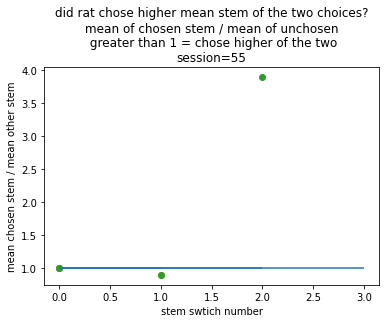

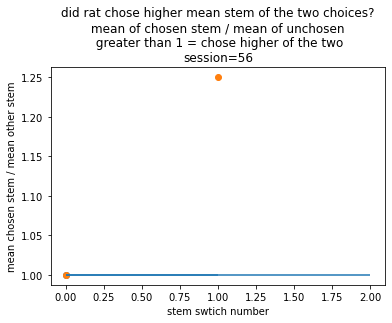

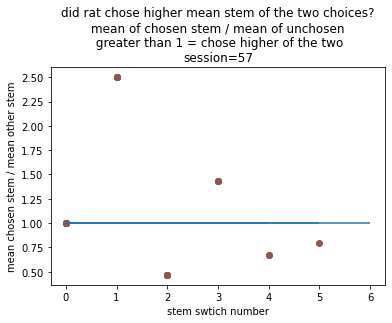

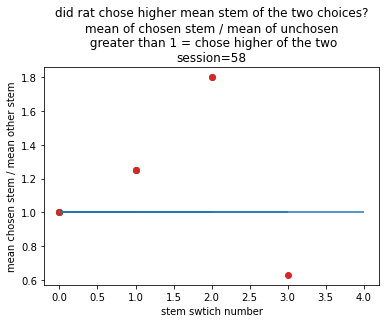

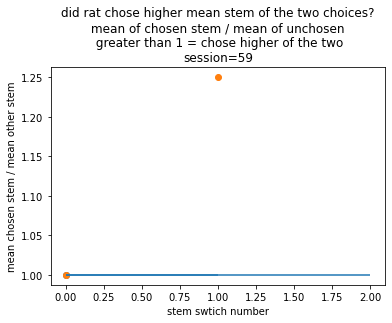

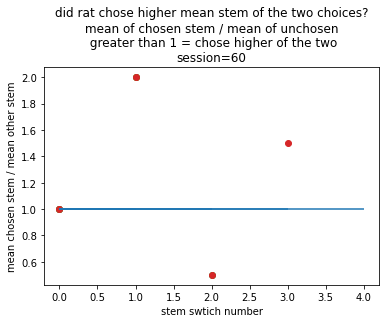

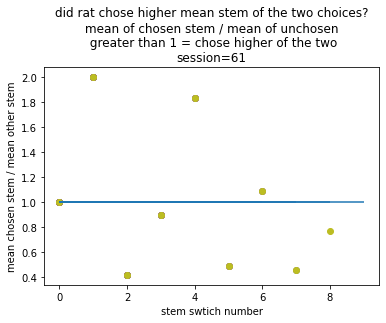

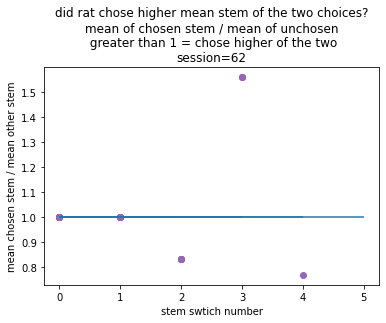

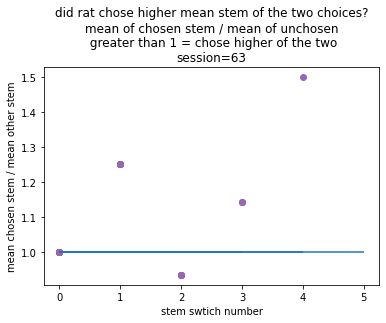

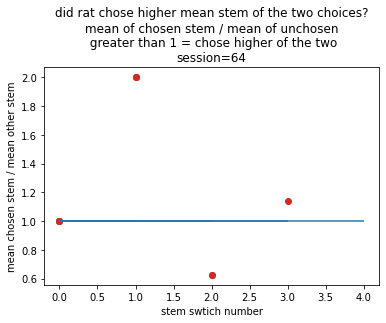

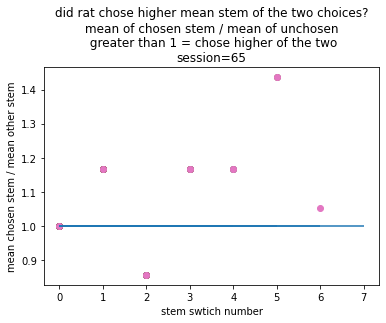

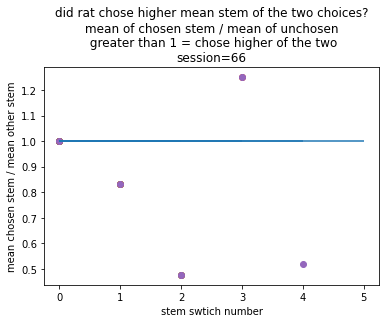

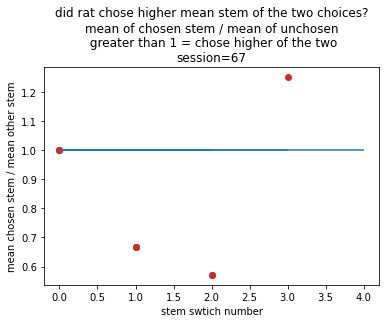

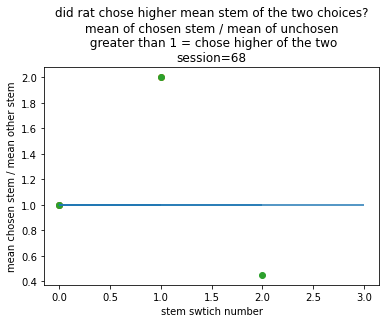

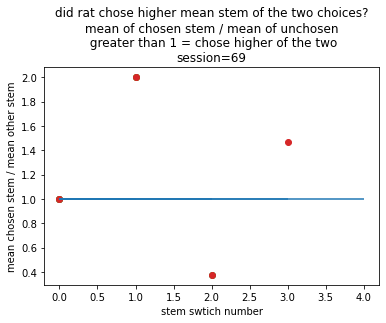

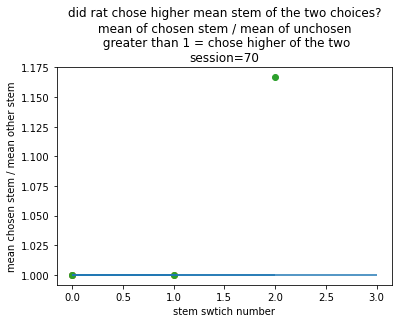

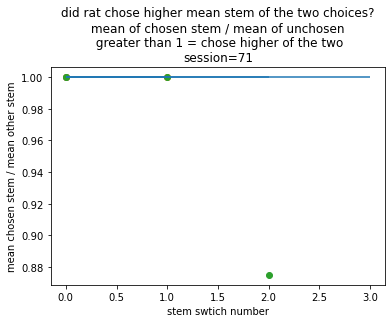

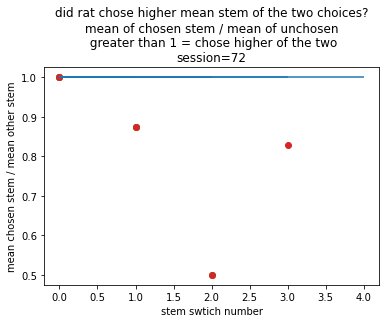

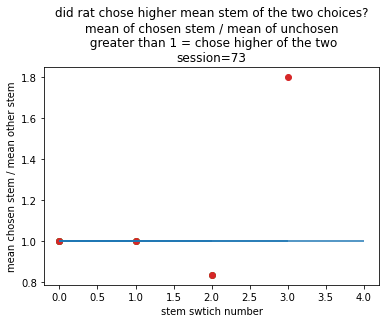

In [23]:
for sess in range(1,(df['sess_chng']).max()):
    plt.figure()
    random_session = df[df['sess_chng']==sess]
    random_session = random_session[random_session['cont_num']==1]
    stemsw = random_session[random_session['stem_switch']]
    var_prop_lst=[]
    for ix in range(1,len(stemsw)):
        index = stemsw.iloc[ix][0]

        stem1=stemsw.iloc[ix-1]['stem']
        stem2=stemsw.iloc[ix]['stem']
        if stem2=='A':
            if stem1 =='B':            
                var_prop= random_session.loc[index-1]['meanA']/random_session.loc[index-1]['meanC']
            if stem1 =='C':
                var_prop= random_session.loc[index-1]['meanA']/random_session.loc[index-1]['meanB']
        if stem2=='B':
            if stem1 =='A':
                var_prop= random_session.loc[index-1]['meanB']/random_session.loc[index-1]['meanC']
            if stem1 =='C':
                var_prop= random_session.loc[index-1]['meanB']/random_session.loc[index-1]['meanA']
        if stem2=='C':
            if stem1 =='A':
                var_prop= random_session.loc[index-1]['meanC']/random_session.loc[index-1]['meanB']
            if stem1 =='B':
                var_prop= random_session.loc[index-1]['meanC']/random_session.loc[index-1]['meanA']          
        var_prop_lst.append(var_prop)
        plt.scatter(range(len(var_prop_lst)),var_prop_lst)
        # plt.ylim(0,8)
        plt.hlines(1,0,len(var_prop_lst))
        plt.xlabel('stem swtich number')
        plt.ylabel('mean chosen stem / mean other stem')
        plt.title(f'did rat chose higher mean stem of the two choices?\n mean of chosen stem / mean of unchosen \n greater than 1 = chose higher of the two\nsession={sess}')

In [90]:
random_session

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,...,visitsC_sesh,rew_a,rew_c,rew_b,meanA,varA,meanB,varB,meanC,varC
12933,12933,4,B,0,805020205020,20201107,5,0,11,1,...,0.0,0.0,0.0,0.0,0.500000,0.083333,0.333333,0.055556,0.500000,0.083333
12934,12934,3,B,1,805020205020,20201107,5,1,11,1,...,0.0,0.0,0.0,1.0,0.500000,0.083333,0.500000,0.050000,0.500000,0.083333
12935,12935,4,B,0,805020205020,20201107,5,2,11,1,...,0.0,0.0,0.0,1.0,0.500000,0.083333,0.400000,0.040000,0.500000,0.083333
12936,12936,3,B,1,805020205020,20201107,5,3,11,1,...,0.0,0.0,0.0,2.0,0.500000,0.083333,0.500000,0.035714,0.500000,0.083333
12937,12937,2,A,0,805020205020,20201107,5,4,11,1,...,0.0,0.0,0.0,2.0,0.333333,0.055556,0.500000,0.035714,0.500000,0.083333
12938,12938,1,A,1,805020205020,20201107,5,5,11,1,...,0.0,1.0,0.0,2.0,0.500000,0.050000,0.500000,0.035714,0.500000,0.083333
12939,12939,2,A,1,805020205020,20201107,5,6,11,1,...,0.0,2.0,0.0,2.0,0.600000,0.040000,0.500000,0.035714,0.500000,0.083333
12940,12940,1,A,1,805020205020,20201107,5,7,11,1,...,0.0,3.0,0.0,2.0,0.666667,0.031746,0.500000,0.035714,0.500000,0.083333
12941,12941,2,A,1,805020205020,20201107,5,8,11,1,...,0.0,4.0,0.0,2.0,0.714286,0.025510,0.500000,0.035714,0.500000,0.083333
12942,12942,1,A,1,805020205020,20201107,5,9,11,1,...,0.0,5.0,0.0,2.0,0.750000,0.020833,0.500000,0.035714,0.500000,0.083333


In [72]:
stem1=stemsw.iloc[ix-1]['stem']
stem1
stem2=stemsw.iloc[ix]['stem']
stem2

'A'

In [73]:
df1.iloc[index-1]['varA']#/df1.iloc[index-1]['varB']


IndexError: single positional indexer is out-of-bounds

In [74]:
df1

,Unnamed: 0,leaf,stem,reward,contingency,date,session,trial,day,cont_num,...,visitsC_sesh,rew_a,rew_c,rew_b,meanA,varA,meanB,varB,meanC,varC
0,0,4,B,1,805020202050,20201028,1,0,1,1,...,0.0,0.0,0.0,1.0,0.500000,0.083333,0.666667,0.055556,0.500000,0.083333
1,1,1,A,0,805020202050,20201028,1,1,1,1,...,0.0,0.0,0.0,1.0,0.333333,0.055556,0.666667,0.055556,0.500000,0.083333
2,2,2,A,0,805020202050,20201028,1,2,1,1,...,0.0,0.0,0.0,1.0,0.250000,0.037500,0.666667,0.055556,0.500000,0.083333
3,3,3,B,1,805020202050,20201028,1,3,1,1,...,0.0,0.0,0.0,2.0,0.250000,0.037500,0.750000,0.037500,0.500000,0.083333
4,4,4,B,0,805020202050,20201028,1,4,1,1,...,0.0,0.0,0.0,2.0,0.250000,0.037500,0.600000,0.040000,0.500000,0.083333
5,5,5,C,0,805020202050,20201028,1,5,1,1,...,1.0,0.0,0.0,2.0,0.250000,0.037500,0.600000,0.040000,0.333333,0.055556
6,6,6,C,1,805020202050,20201028,1,6,1,1,...,2.0,0.0,1.0,2.0,0.250000,0.037500,0.600000,0.040000,0.500000,0.050000
7,7,1,A,1,805020202050,20201028,1,7,1,1,...,2.0,1.0,1.0,2.0,0.400000,0.040000,0.600000,0.040000,0.500000,0.050000
8,8,2,A,1,805020202050,20201028,1,8,1,1,...,2.0,2.0,1.0,2.0,0.500000,0.035714,0.600000,0.040000,0.500000,0.050000
9,9,3,B,0,805020202050,20201028,1,9,1,1,...,2.0,2.0,1.0,2.0,0.500000,0.035714,0.500000,0.035714,0.500000,0.050000


In [64]:
stem1=stemsw.iloc[ix-1]['stem']
stem2=stemsw.iloc[ix]['stem']



In [62]:
stem1

'B'

In [63]:
stem2

'A'

In [ ]:
for sess in range(1,(df['sess_chng']).max()):
    plt.figure()
    random_session = df[df['sess_chng']==sess]
    random_session = random_session[random_session['cont_num']==1]
    stemsw = random_session[random_session['stem_switch']]
    var_diff_lst=[]
    for ix in range(1,len(stemsw)):
        index = stemsw.iloc[ix][0]

        stem1=stemsw.iloc[ix-1]['stem']
        stem2=stemsw.iloc[ix]['stem']
        if stem2=='A':
            if stem1 =='B':            
                var_diff= random_session.loc[index-1]['varA']-random_session.loc[index-1]['varC']
            if stem1 =='C':
                var_diff= random_session.loc[index-1]['varA']-random_session.loc[index-1]['varB']
        if stem2=='B':
            if stem1 =='A':
                var_diff= random_session.loc[index-1]['varB']-random_session.loc[index-1]['varC']
            if stem1 =='C':
                var_diff= random_session.loc[index-1]['varB']-random_session.loc[index-1]['varA']
        if stem2=='C':
            if stem1 =='A':
                var_diff= random_session.loc[index-1]['varC']-random_session.loc[index-1]['varB']
            if stem1 =='B':
                var_diff= random_session.loc[index-1]['varC']-random_session.loc[index-1]['varA']          
        var_diff_lst.append(var_diff)
        plt.scatter(range(len(var_diff_lst)),var_diff_lst)
        # plt.ylim(0,8)
        plt.hlines(0,0,len(var_diff_lst))
        plt.xlabel('stem swtich number')
        plt.ylabel('var chosen stem / var other stem')
        plt.title(f'did rat chose higher var stem of the two choices?\n var of chosen stem - var of unchosen \n greater than 1 = chose higher of the two\nsession={sess}')

In [ ]:
for sess in range(1,(df['sess_chng']).max()):
    plt.figure()
    random_session = df[df['sess_chng']==sess]
    random_session = random_session[random_session['cont_num']==1]
    stemsw = random_session[random_session['stem_switch']]
    var_diff_lst=[]
    for ix in range(1,len(stemsw)):
        index = stemsw.iloc[ix][0]

        stem1=stemsw.iloc[ix-1]['stem']
        stem2=stemsw.iloc[ix]['stem']
        if stem2=='A':
            if stem1 =='B':            
                var_diff= random_session.loc[index-1]['meanA']-random_session.loc[index-1]['meanC']
            if stem1 =='C':
                var_diff= random_session.loc[index-1]['meanA']-random_session.loc[index-1]['meanB']
        if stem2=='B':
            if stem1 =='A':
                var_diff= random_session.loc[index-1]['meanB']-random_session.loc[index-1]['meanC']
            if stem1 =='C':
                var_diff= random_session.loc[index-1]['meanB']-random_session.loc[index-1]['meanA']
        if stem2=='C':
            if stem1 =='A':
                var_diff= random_session.loc[index-1]['meanC']-random_session.loc[index-1]['meanB']
            if stem1 =='B':
                var_diff= random_session.loc[index-1]['meanC']-random_session.loc[index-1]['meanA']          
        var_diff_lst.append(var_diff)
        plt.scatter(range(len(var_diff_lst)),var_diff_lst)
        # plt.ylim(0,8)
        plt.hlines(1,0,len(var_diff_lst))
        plt.xlabel('stem swtich number')
        plt.ylabel('mean chosen stem / mean other stem')
        plt.title(f'did rat chose higher mean stem of the two choices?\n mean of chosen stem / mean of unchosen \n greater than 1 = chose higher of the two\nsession={sess}')

In [100]:
# okay so lines dont converge, I could ask if the rat visits the higher variance more at the beginning of the session somehow vs the end... 
#some sessions only have 3 stems switches, whats the beginning at the end? Should it be by trial number? 

In [ ]:
#or proportion of stem switches per session that he chooses to go to the sten with the higher variance 